In [1]:
import sys
sys.path.append('/nfs/homedirs/giri/masterthesis')

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
from robust_priornet.utils.visualizer import plot_adv_samples, plot_all_pr_curves, plot_all_roc_curves, plot_adv_samples_ood
from robust_priornet.eval.uncertainty import UncertaintyMeasuresEnum
from robust_priornet.eval.model_prediction_eval import ClassifierPredictionEvaluator
from robust_priornet.attack_priornet import plot_ood_attack_success

In [3]:
model_dir="runtime-model-vgg6-50epochs"
batch_size=64
n_in=28
num_channels=1
data_dir="./runtime-data"
in_dataset="MNIST"
ood_dataset="SVHN"

### Utils

In [4]:
def display_pr_roc_curves(model_dir, eval_dir, uncertainty_measure: UncertaintyMeasuresEnum):
    #figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,20))
    img = Image.open(os.path.join(model_dir, eval_dir, f'{uncertainty_measure._value_}_PR_Curve.png'))
    display(img)
    img = Image.open(os.path.join(model_dir, eval_dir, f'{uncertainty_measure._value_}_ROC_Curve.png'))
    display(img)

In [5]:
def create_vis_plots(org_eval_dir, attack_dir, epsilon, plots_dir='vis', misclassified_indices=[], limit=None):
    # all images are saved in 'vis' directory under attack folder
    misclassified_samples = plot_adv_samples(org_eval_dir, attack_dir, epsilon, plots_dir, misclassified_indices, limit=limit)

    last_batch = misclassified_samples - (misclassified_samples%10) if limit is None else (limit-10)
    display(Image.open(f"{attack_dir}/e{epsilon}-attack/{plots_dir}/result_vis_{last_batch}.png")) # prints the last but one batch

## Eval task on val set - MNIST , SVHN

### OOD-detect task

In [6]:
out_dir=model_dir+"/ood-eval-val-svhn"
cmd = f"python -m robust_priornet.eval_priornet --gpu -1 --batch_size {batch_size} --task ood_detect --val_dataset --model_dir {model_dir} --result_dir {out_dir} {data_dir} {in_dataset} {ood_dataset}"
print(cmd)

python -m robust_priornet.eval_priornet --gpu -1 --batch_size 64 --task ood_detect --val_dataset --model_dir runtime-model-vgg6-50epochs --result_dir runtime-model-vgg6-50epochs/ood-eval-val-svhn ./runtime-data MNIST SVHN


In [7]:
os.system(cmd)

0

## Attack in-domain and eval ood-detect task on validation set
### In-domain samples are transformed to adversarial samples, out domain samples are also transformed to adversarial samples  - then evaluated for ood-detect task

OOD dataset used is different from the one the model was trained on. Model was trained on OMNIGLOT, we attack SVHN dataset and provide it as out distribution samples.

### Diff entropy attack

In [8]:
out_dir=model_dir+"/attack-fgsm-val-ood-svhn"

epsilon_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
epsilons = " ".join(map(lambda x: str(x),epsilon_list))

cmd = f"python -m robust_priornet.attack_priornet --gpu -1 --batch_size {batch_size} --attack_type FGSM --attack_criteria diff_entropy --val_dataset --ood_eval --ood_dataset {ood_dataset} --epsilon {epsilons} --model_dir {model_dir} {data_dir} {in_dataset} {out_dir}"
print(cmd)

python -m robust_priornet.attack_priornet --gpu -1 --batch_size 64 --attack_type FGSM --attack_criteria diff_entropy --val_dataset --ood_eval --ood_dataset SVHN --epsilon 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 --model_dir runtime-model-vgg6-50epochs ./runtime-data MNIST runtime-model-vgg6-50epochs/attack-fgsm-val-ood-svhn


In [9]:
os.system(cmd)

0

#### Attack's epsilon curve - diff entropy

In [11]:
thresholds = [-18.52049,-14.93081,-13.73132,-13.20055,-13.10584,-13.00481,-12.92809,-12.88405,-12.83937,-12.83091]

In [12]:
result_dir = os.path.join(out_dir, 'ood-success-dentropy')
os.makedirs(result_dir)
plot_ood_attack_success(epsilon_list, UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY, thresholds, out_dir, result_dir)

epsilon: 0.1, threshold: -18.52049
tn: 4267, fp: 1733, fn: 756, tp: 6569, total_id: 6000, total_ood: 7325
epsilon: 0.2, threshold: -14.93081
tn: 3985, fp: 2015, fn: 1478, tp: 5847, total_id: 6000, total_ood: 7325
epsilon: 0.3, threshold: -13.73132
tn: 4216, fp: 1784, fn: 1458, tp: 5867, total_id: 6000, total_ood: 7325
epsilon: 0.4, threshold: -13.20055
tn: 4795, fp: 1205, fn: 1484, tp: 5841, total_id: 6000, total_ood: 7325
epsilon: 0.5, threshold: -13.10584
tn: 4502, fp: 1498, fn: 1160, tp: 6165, total_id: 6000, total_ood: 7325
epsilon: 0.6, threshold: -13.00481
tn: 4466, fp: 1534, fn: 1135, tp: 6190, total_id: 6000, total_ood: 7325
epsilon: 0.7, threshold: -12.92809
tn: 4526, fp: 1474, fn: 1312, tp: 6013, total_id: 6000, total_ood: 7325
epsilon: 0.8, threshold: -12.88405
tn: 4267, fp: 1733, fn: 1502, tp: 5823, total_id: 6000, total_ood: 7325
epsilon: 0.9, threshold: -12.83937
tn: 4231, fp: 1769, fn: 1957, tp: 5368, total_id: 6000, total_ood: 7325
epsilon: 1.0, threshold: -12.83091
tn:

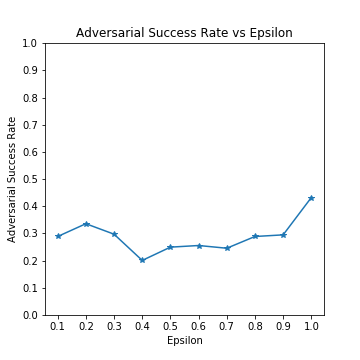

In [13]:
# Plotting in domain adversarial success, in domain sample falsly classified as out domain sample
display(Image.open(os.path.join(out_dir, 'ood-success-dentropy', 'epsilon-curve_id.png')))

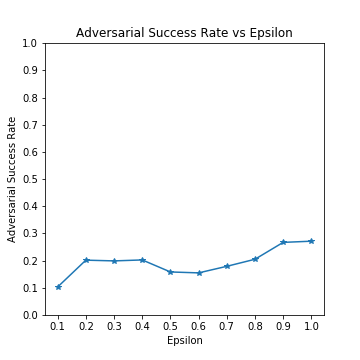

In [14]:
# Plotting out domain adversarial success, out domain sample falsly classified as in domain sample
display(Image.open(os.path.join(out_dir, 'ood-success-dentropy', 'epsilon-curve_ood.png')))

In [10]:
# same measure before attack (using threshold value based on no attack eval, tpr=1.0, fpr=0.001)
id_dist_un = np.loadtxt(os.path.join(model_dir, 'ood-eval-val-svhn', 'id_differential_entropy.txt'))
ood_dist_un = np.loadtxt(os.path.join(model_dir, 'ood-eval-val-svhn', 'ood_differential_entropy.txt'))
y_preds = np.concatenate((id_dist_un, ood_dist_un), axis=0)
y_true = np.concatenate((np.zeros_like(id_dist_un), np.ones_like(ood_dist_un)), axis=0)
tn, fp, fn, tp = ClassifierPredictionEvaluator.compute_confusion_matrix_entries(y_preds, y_true, -19.03791)
print(f"tn: {tn}, fp: {fp}, fn: {fn}, tp: {tp}, total: {len(y_true)}")

tn: 5954, fp: 46, fn: 0, tp: 7325, total: 13325


#### Some adversarial samples

In [15]:
org_eval_dir = os.path.join(model_dir, 'ood-eval-val-svhn')
plot_adv_samples_ood(org_eval_dir, out_dir, 0.5, thresholds[4], UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY, limit=100)

Cross check: fp: 1498
Cross check: fn: 1160


2658

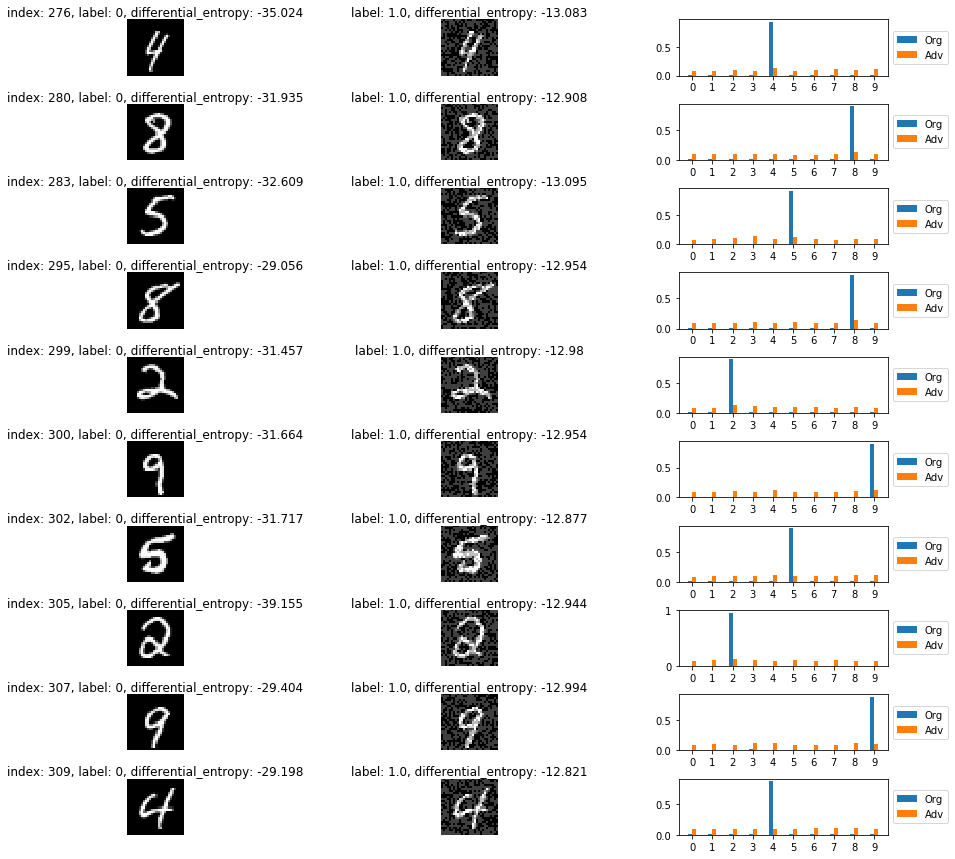

In [16]:
# in domain --> out domain (adversarial success for attacking in domain samples)
display(Image.open(os.path.join(out_dir, f'e0.5-attack', 'vis', 'in-out', 'result_vis_100.png')))

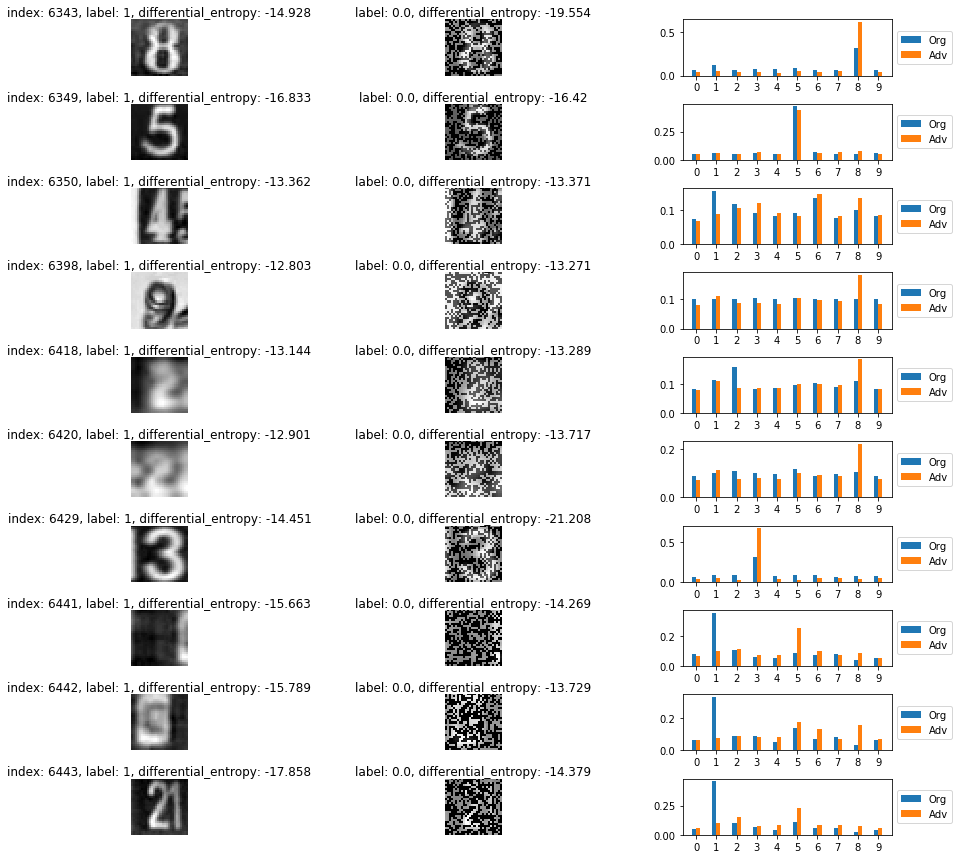

In [17]:
# out domain --> in domain (adversarial success for attacking out domain samples)
display(Image.open(os.path.join(out_dir, f'e0.5-attack', 'vis', 'out-in', 'result_vis_60.png')))

# note the overall reduction in prob value (third column) when compared to in-domain samples.

#### PR and ROC curves (before and after attack)

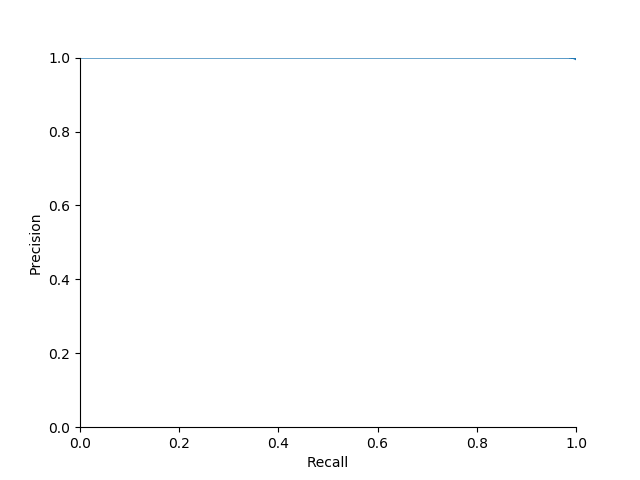

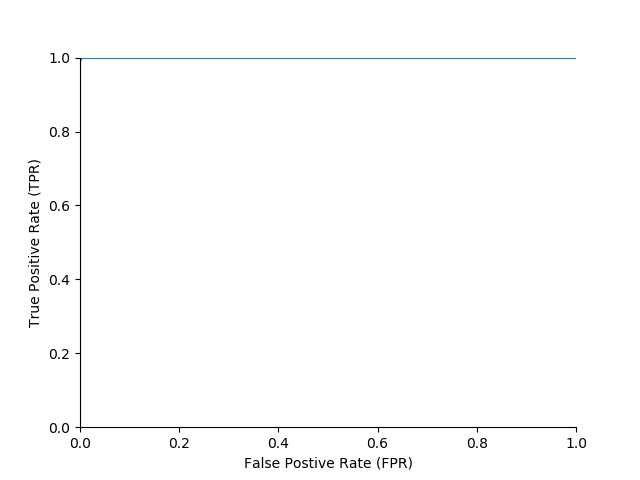

In [18]:
# model before attack
display_pr_roc_curves(model_dir, 'ood-eval-val-svhn', UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY)

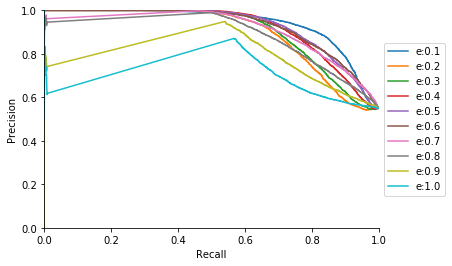

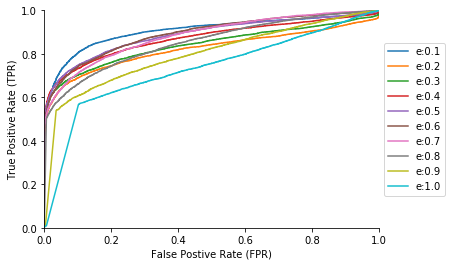

In [19]:
# model under attack
attack_dir=os.path.join(model_dir, "attack-fgsm-val-ood-svhn")
measure = UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY
plot_all_roc_curves(epsilon_list, attack_dir, 'ood_eval', measure, attack_dir)
plot_all_pr_curves(epsilon_list, attack_dir, 'ood_eval', measure, attack_dir)

display(Image.open(os.path.join(attack_dir, f"{measure._value_}_PR_summary.png")))
display(Image.open(os.path.join(attack_dir, f"{measure._value_}_ROC_summary.png")))